In [81]:
from scipy import stats
import numpy as np 
import seaborn as sns
from random import randint, random
import matplotlib.pyplot as plt

In [2]:
def randomList(m: int, n: int, min_val:int=1) -> list[int]: 
    '''
    generate a list of m integers that sum to n, with a minimum value
    '''

    arr = [min_val] * m; 

    # what is left to distribute
    left = n - 1 - m*min_val
     
    # while there is still something to distribute
    while (left >= 0):
        if random() < 0.3:
            arr[randint(0, n) % m] += 1; 
            left -= 1
        else:
            arr[randint(0, n) % m] += min(5, left+1) 
            left -= 5
 
    return arr

## Setup

In [83]:
G = 6 # number of groups
T = 60 # number of time periods
N = 1000 # number of individuals
K = 100 # number of tickets that can be sold (capacity of plane)

wtp_g = stats.halfnorm.rvs(loc=4, scale=4, size=G) # location of wtp distribution for each group
wtps_g = stats.halfnorm.rvs(loc=2, scale=2, size=G) # scale of wtp distribution for each group

group_sizes = randomList(G, N)  #np.random.dirichlet([1]*G)

## Looking at the Resulting Distributions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


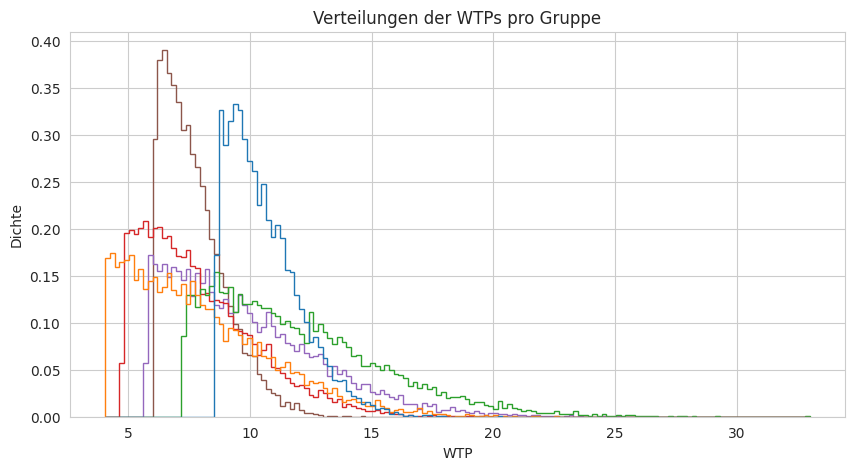

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
r = stats.halfnorm.rvs(size=(N*10, G), scale=wtps_g, loc=wtp_g)
ax.hist(r, density=True, bins='auto', histtype='step', alpha=1)
# ax.set_xlim([x[0], x[-1]])

ax.legend(loc='best', frameon=False)
ax.set_title('Verteilungen der WTPs pro Gruppe')
ax.set_xlabel('WTP')
ax.set_ylabel('Dichte')
plt.show()

In [85]:
wtp = stats.halfnorm.rvs(loc=wtp_g, scale=wtp_g, size=(N, G))

In [86]:
wtp.mean(axis=0)

array([15.61567779,  7.2573288 , 12.93281124,  8.54717831, 10.20208057,
       10.67518815])

In [87]:
def init_occurences(T, group_sizes) -> list[list[int]]:
    occurences = []

    for g in group_sizes:
        start = np.random.choice(range(10,20))
        end = np.random.choice(range(35,45))

        print(end-start, g)

        occurences.append(
            [0]*start +
            randomList(end-start, g) + 
            [0]*(T-end)
        )

    return occurences


In [88]:
occ = np.array(init_occurences(T, group_sizes))

29 162
24 162
27 167
26 144
29 180
26 185


In [89]:
wtp_group_mean = wtp.mean(axis=0)

Text(0.5, 1.0, 'Occurences of groups over time')

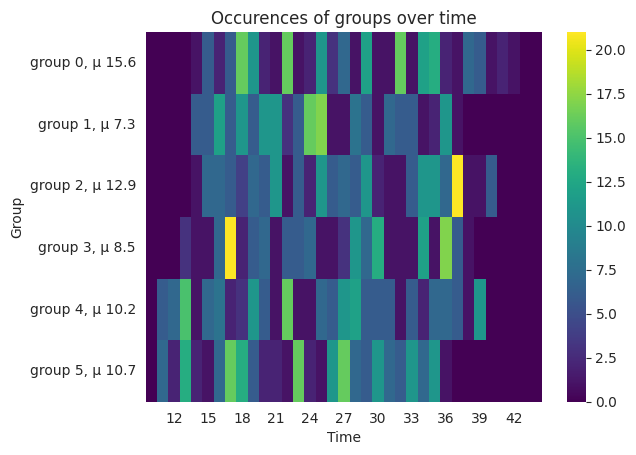

In [91]:
fig, ax = plt.subplots(1, 1)
sns.heatmap(occ, ax=ax, cmap='viridis')
ax.set_xlabel('Time')
ax.set_ylabel('Group')
ax.set_yticklabels(['group {}, µ {}'.format(i, round(wtp_group_mean[i], 1)) for i in range(G)])

ax.set_xlim([10, 45])

# rotate y labels
plt.yticks(rotation=0)

ax.set_title('Occurences of groups over time')

In [92]:
n_offered = np.array(randomList(T, K) )

In [93]:
price = np.random.normal(5, 2, size=T)    

# check: for a price of 0 we should get N individuals who are willing to pay
# price = [0.1] * T

In [94]:
def n_willing(price:np.ndarray, occ:np.ndarray, wtps_g:np.ndarray) -> np.ndarray:
    """
    returns the number of individuals willing to buy a ticket at a given price
    """
    
    
    tickets_bought = [0]*T

    for grp_idx, group in enumerate(occ):
        for t_idx, n_occ in enumerate(group):

            price_t = price[t_idx]

            if n_occ == 0:
                continue

            wtp = stats.halfnorm.rvs(loc=0, scale=wtps_g[grp_idx], size=n_occ)

            tickets_bought_t = sum(price_t < wtp)
            tickets_bought[t_idx] += tickets_bought_t

            # print(n_occ, wtp, tickets_bought_t, price_t)
        
    return np.array(tickets_bought)

In [95]:
def n_tickets_sold(n_tickets_offered, n_tickets_willing)->np.ndarray:
    """
    returns the number of tickets sold
    """
    return np.min(np.concatenate([n_tickets_offered.reshape(-1, 1), n_tickets_willing.reshape(-1,1)], axis=1), axis=1)

In [114]:
def objective(price: np.ndarray, n_tickets_offered: np.ndarray) -> float:
    """
    returns the revenue
    """
    global N_EVALS
    N_EVALS += 1

    n_tickets_willing = n_willing(price, occ, wtps_g)
    sold = n_tickets_sold(n_tickets_offered, n_tickets_willing)
    return sum(sold*price)

In [97]:
objective(price, n_offered)

194.71317050673343

In [99]:
def mutate_price(price:np.ndarray) -> np.ndarray:
    """
    mutate the
    """
    price_new = price.copy()
    price_idx = randint(0, T-1)

    price_new[price_idx] = price[price_idx] + np.random.normal(0, price.std())
    
    return price_new

In [100]:
def mutate_n_tickets_sold(n_tickets_sold:np.ndarray, resample_length: int=3):
    """
    mutate the n_tickets sold by resampling a section of the genes
    """
    n_tickets_sold_new = n_tickets_sold.copy()


    resample_length = resample_length
    idx = randint(0, T-1-resample_length)

    n_tickets_sold_new[idx:idx+resample_length] = randomList(resample_length, K)

    return n_tickets_sold_new

In [101]:
def recombine_price(price1:np.ndarray, price2:np.ndarray):
    """
    recombine two prices
    """
    price_new = price1.copy()

    idx = randint(0, T-1)

    price_new[:idx] = price1[:idx]
    price_new[idx:] = price2[idx:]

    return price_new

def recombine_n_tickets_sold(n_tickets_sold1:np.ndarray, n_tickets_sold2:np.ndarray):
    """
    recombine two n_tickets_sold
    """
    n_tickets_sold_new = n_tickets_sold1.copy()

    idx = randint(0, T-1)

    n_tickets_sold_new[:idx] = n_tickets_sold1[:idx]
    n_tickets_sold_new[idx:] = n_tickets_sold2[idx:]

    return n_tickets_sold_new

In [102]:
def init_individual():
    return np.random.normal(5, 2, size=T), np.array(randomList(T, K))

## Testing Mutation

In [103]:
best = 0
best_price = None
best_offered = None
improvements = []

for i in range(100):
    price, n_offered = init_individual()

    o = objective(price, n_offered)

    price_mut = mutate_price(price)
    # n_offered_mut = mutate_n_tickets_sold(n_offered)

    o_mut = objective(price_mut, n_offered)

    # if o_mut > o:
    #     best += 1
    #     print(o_mut, o)

    improvements.append(o_mut-o)

# if o > best:
#     best = o
#     best_price = price
#     best_offered = n_offered
#     print(o)

## testing recombination

In [ ]:
best = 0

for i in range(100):
    price1, n_offered1 = init_individual()
    price2, n_offered2 = init_individual()

    o1 = objective(price1, n_offered1)
    o2 = objective(price2, n_offered2)

    price_new = recombine_price(price1, price2)
    n_offered_new = recombine_n_tickets_sold(n_offered1, n_offered2) 

    o_new = objective(price_new, n_offered_new)

    if o_new > o1 and o_new > o2:
        best += 1
        print(o_new, o1, o2)

## Implementing GA

In [109]:
def roulette_selection(individuals, objs: list[float], n_selected: int):
    """
    select individuals based on their objective values
    -> roulette wheel selection
    """
    n = len(individuals)

    # sort individuals by objective value
    sorted_individuals = [ind for _, ind in sorted(zip(objs, individuals), key=lambda pair: pair[0], reverse=True)]

    # select the best n_selected individuals
    return np.array(sorted_individuals[:n_selected])

In [112]:
N_ITER = 100
POP_SIZE = 100
N_CHILDREN = 100
MUTATION_RATE = 0.30
REAMPLE_LENGTH = 3
N_EVALS = 0

population_current = np.array([init_individual() for _ in range(POP_SIZE)])
obj_stats = []

for i in range(10):
    objs = [objective(*ind) for ind in population_current]
    objs_norm = objs/sum(objs)
    obj_stats.append(objs)

    print(np.array(objs).mean())

    children = []
    for j in range(N_CHILDREN):

        # sample two parents based on their objective values
        parents = np.random.choice(np.array(range(POP_SIZE)), size=2, p=objs_norm, replace=False)
        
        # recombine parents to obtain new price
        child_price = recombine_price(population_current[parents[0], 0, :], population_current[parents[1], 0, :])
        
        # recombine parents to obtain new n_tickets_sold
        child_offered = recombine_n_tickets_sold(population_current[parents[0], 1, :], population_current[parents[1], 1, :])

        children.append([child_price, child_offered])

    # mutate the children
    for child in children:
        if np.random.rand() < MUTATION_RATE:
            child[0] = mutate_price(child[0])
            child[1] = mutate_n_tickets_sold(child[1], resample_length=REAMPLE_LENGTH)

    objs_new = [objective(*ind) for ind in children]

    # temporarily add children to population
    population_current = np.concatenate([population_current, children], axis=0)

    # reduce population size again
    population_current = roulette_selection(population_current, np.concatenate([objs, objs_new]), n_selected=POP_SIZE)

209.07605835582154
232.93494999701466
265.49815121648743
300.14161353886817
341.367419767614
376.6271291352014
425.5362415835414
468.13249124395867
524.6283182331686
580.4992572582768


In [78]:
obj_stats = np.array(obj_stats)

<Axes: title={'center': 'Objective values over iterations'}, xlabel='Iteration', ylabel='Objective value'>

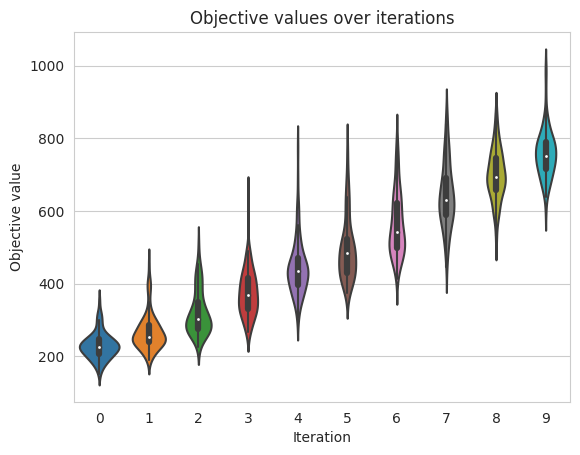

In [79]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1)
ax.set_title('Objective values over iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('Objective value')
sns.violinplot(data=obj_stats.T)

In [ ]:
# 2 * T * pop_size * it

In [ ]:
np.random.choice()